<a href="https://colab.research.google.com/github/davidgonmar/pid-car-model-classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import userdata

# Debe estar configurado en los secretos de Google Colab
kaggle_username = userdata.get("kaggle_username")
kaggle_key = userdata.get("kaggle_key")

if not kaggle_username or not kaggle_key:
    raise ValueError("Kaggle API credentials not found in userdata. Please register them correctly.")


os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

print("✅ Kaggle API authenticated successfully!")

✅ Kaggle API authenticated successfully!


In [7]:
!kaggle datasets download -d rickyyyyyyy/torchvision-stanford-cars -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/rickyyyyyyy/torchvision-stanford-cars
License(s): other
... resuming from 0 bytes (1959684336 bytes left) ...
100% 1.82G/1.83G [01:22<00:00, 24.3MB/s]
100% 1.83G/1.83G [01:22<00:00, 23.7MB/s]


In [10]:
import torch
import torchvision

In [26]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.Normalize((0.5,) * 3, (0.5,) * 3 ),

])

dataset_path = "/content"


class StanfordCars(torch.utils.data.Dataset):
    def __init__(self, root, split='train', transform=None, crop=True):
        import scipy
        self.root = root
        self.split = split
        self.transform = transform
        self.crop = crop

        self._samples = []
        self._targets = []


        p = root + '/stanford_cars/cars_test_annos_withlabels.mat' if split == 'test' else root + '/stanford_cars/devkit/cars_train_annos.mat'
        data = scipy.io.loadmat(p)
        #print(data)
        da = data["annotations"][0]
        #print(da)
        #print(data)
        # each datum has bbbox_x1, bbox_x2, bbox_y1, bbox_y2, class, fname
        self._samples = [
              {"bbox": [int(a[0]), int(a[1]), int(a[2]), int(a[3])], "class": int(a[4]) - 1, "fname": str(a[5][0])}
              for a in da
        ]
        self.imgpath =  '/stanford_cars/cars_train/' if self.split == 'train' else '/stanford_cars/cars_test/'
    def __len__(self):
        return len(self._samples)

    def __getitem__(self, idx):
        sample = self._samples[idx]
        img = torchvision.io.read_image(self.root + self.imgpath + sample["fname"])
        cl = sample["class"]
        if self.crop:
            img = torchvision.transforms.functional.crop(img, sample["bbox"][1], sample["bbox"][0], sample["bbox"][3] - sample["bbox"][1], sample["bbox"][2] - sample["bbox"][0])

        img = img.float()
        if img.shape[0] == 1:
            img = torch.cat((img, img, img), dim=0)
        if self.transform:
            img = self.transform(img)

        return img, cl
train_dataset = StanfordCars(root=dataset_path, split='train', transform=transform, crop=True)
test_dataset = StanfordCars(root=dataset_path, split='test', transform=transform, crop=True)

print("🚗 Stanford Cars dataset loaded successfully!")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<ipython-input-26-3459d4d60fa4>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  {"bbox": [int(a[0]), int(a[1]), int(a[2]), int(a[3])], "class": int(a[4]) - 1, "fname": str(a[5][0])}


🚗 Stanford Cars dataset loaded successfully!


In [27]:
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
resnet.fc = torch.nn.LazyLinear(196)
r = resnet.to(device)
print(device)

cuda


In [28]:
subset_size = 5000
indices = torch.randperm(len(test_dataset))[:subset_size]
test_dataloader = DataLoader(Subset(test_dataset, indices), batch_size=64)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [29]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn

# Freeze layers except for the last block and the fully connected layer
for name, param in resnet.named_parameters():
    if not ("layer4" in name or "layer3" in name or "fc" in name):
        param.requires_grad = False

# Set up the optimizer with differential learning rates:
# - New fc layer: higher lr (e.g., 1e-3)
# - Unfrozen pretrained layers: lower lr (e.g., 1e-4)
optimizer = optim.AdamW([
    {'params': resnet.fc.parameters(), 'lr': 1e-3}, # layer 3
    {'params': [param for name, param in resnet.named_parameters()
                if param.requires_grad and "fc" not in name and "layer3" not in name], 'lr': 1e-4}, # layer 4
    {'params': [param for name, param in resnet.named_parameters()
                if param.requires_grad and "fc" not in name and "layer4" not in name], 'lr': 3e-5} # layer 3
], weight_decay=1e-4)

# Cosine annealing scheduler for state-of-the-art LR scheduling
scheduler = CosineAnnealingLR(optimizer, T_max=25)

criterion = nn.CrossEntropyLoss()

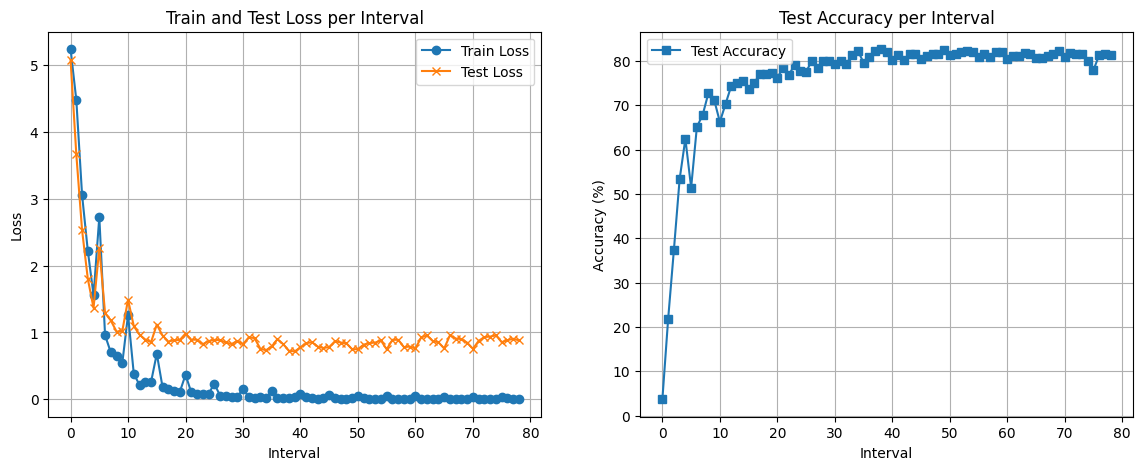

Epoch 16/100:  78%|███████▊  | 100/128 [04:33<07:08, 15.30s/it]

Epoch [16/100], Interval [100], Train Loss: 0.0081, Test Loss: 0.8816, Test Accuracy: 81.42%


Epoch 16/100:  97%|█████████▋| 124/128 [05:38<00:10,  2.73s/it]


KeyboardInterrupt: 

In [30]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return avg_loss, accuracy


train_losses, test_losses, test_accuracies = [], [], []

resnet.to(device)

interval = len(train_dataloader) // 5

for ep in range(100):
    resnet.train()
    running_loss = 0.0
    scheduler.step()
    for batch_idx, (data, target) in enumerate(tqdm(train_dataloader, desc=f'Epoch {ep+1}/100'), 1):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = resnet(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % interval == 0:
            avg_train_loss = running_loss / interval
            train_losses.append(avg_train_loss)
            running_loss = 0.0

            # Evaluate on test set
            test_loss, test_accuracy = evaluate_model(resnet, test_dataloader, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            # Plot Loss and Accuracy
            clear_output(wait=True)
            plt.figure(figsize=(14,5))

            plt.subplot(1,2,1)
            plt.plot(train_losses, marker='o', label='Train Loss')
            plt.plot(test_losses, marker='x', label='Test Loss')
            plt.xlabel('Interval')
            plt.ylabel('Loss')
            plt.title('Train and Test Loss per Interval')
            plt.legend()
            plt.grid(True)

            plt.subplot(1,2,2)
            plt.plot(test_accuracies, marker='s', label='Test Accuracy')
            plt.xlabel('Interval')
            plt.ylabel('Accuracy (%)')
            plt.title('Test Accuracy per Interval')
            plt.legend()
            plt.grid(True)

            plt.show()

            print(f'Epoch [{ep+1}/100], Interval [{batch_idx}], Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

